In [1]:
import numpy as np 
import pandas as pd 
import json
import re

from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
# import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = '../../archive'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_20375/41591852.py:3: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(metadata_path, dtype={


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


## Choose paper to process

- 2021 or newer
- delete with missing abstract
- delete with duplicated abstract

In [3]:
meta_df = meta_df[meta_df.publish_time>='2021']
print(f'There are {len(meta_df)} articles published from 2021')

There are 541665 articles published from 2021


In [4]:
len1 = len(meta_df)
meta_df.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(meta_df)} articles with missing abstract')

Dropped 100095 articles with missing abstract


In [5]:
len1 = len(meta_df)
meta_df.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(meta_df)} articles with duplicate abstract')

Dropped 47551 articles with duplicate abstract


In [6]:
meta_df.count()

cord_uid            394019
sha                 169267
source_x            394019
title               393972
doi                 289955
pmcid               164313
pubmed_id           199711
license             394019
abstract            394019
publish_time        394019
authors             392821
journal             359234
mag_id                   0
who_covidence_id    171060
arxiv_id              7206
pdf_json_files      169267
pmc_json_files      146622
url                 297980
s2_id               368222
dtype: int64

In [7]:
import random

random.seed(42)

data = meta_df.sample(n=10000)

## Stopwords

In [9]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['something',
 'whose',
 'amount',
 'otherwise',
 'yours',
 'seems',
 'serious',
 'so',
 'neither',
 'much']

In [10]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)
        
lst_stopwords = stopwords

In [11]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
# stopwords = set(stopwords.words('english'))
data['abstract_clean'] = data['abstract'].apply(lambda x: x.split())

## Remove non-English words
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if w not in lst_stopwords])

## Remove words with single characters
data['abstract_clean'] = data['abstract_clean'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
202740,kqaukp05,NaN,WHO,Quality of Transition to E-Learning under Coro...,10.48047/rigeo.11.05.338,NaN,NaN,unk,e-learning is a lifeline for the educational p...,2021,"Albayatey, A. S. W.; Mawlood, S. J.; Makttoof,...",Review of International Geographical Education...,NaN,#covidwho-1479352,NaN,NaN,NaN,https://doi.org/10.48047/rigeo.11.05.338,244976770.0,"[lifeline, educational, contributed, sustainab..."
286505,b7rg0cf8,NaN,Medline,[Prevalence of anxiety and depression in patie...,NaN,NaN,34783781,unk,introduction the covid-19 pandemic and the san...,2021-09-01,"Cerezo, Gustavo H; Vicario, Augusto",Vertex,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34783781/,244131323.0,"[introduction, pandemic, sanitary, measures, i..."
163679,kgzcs6ds,NaN,Medline,Outcomes of Renal Transplant Recipients With S...,10.1097/tp.0000000000003406,NaN,33350626,unk,background patients with chronic kidney diseas...,2021-01-01,"Mohamed, Ismail H; Chowdary, Prashanth B; Shet...",Transplantation,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1097/tp.0000000000003406; h...,225506778.0,"[background, patients, chronic, kidney, diseas..."
883163,futoxnf0,190acd0eca138805e398f7e49dcdc88aa69a7e45,Medline; PMC,Digital Eye Strain and Its Risk Factors Among ...,10.7759/cureus.13575,PMC8007199,33815983,cc-by,background: several ocular and visual symptoms...,2021-02-26,"Gammoh, Yazan",Cureus,NaN,NaN,NaN,document_parses/pdf_json/190acd0eca138805e398f...,document_parses/pmc_json/PMC8007199.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33815983/;...,232479232.0,"[ocular, visual, symptoms, resulting, use, dig..."
754197,c3kb5beo,bd0828b38105e6b1ce39a9034b30fba2b63877ec,Medline; PMC,The Comparative Clinical Performance of Four S...,10.3390/jcm10020328,PMC7830733,33477365,cc-by,due to globally rising numbers of severe acute...,2021-01-17,"Kohmer, Niko; Toptan, Tuna; Pallas, Christiane...",J Clin Med,NaN,NaN,NaN,document_parses/pdf_json/bd0828b38105e6b1ce39a...,document_parses/pmc_json/PMC7830733.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33477365/;...,231679248.0,"[globally, rising, numbers, severe, acute, res..."


In [12]:
data.reset_index(drop=True,inplace=True)

In [13]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_clean'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 43556 unique words in inverted index


In [14]:
data['abstract_clean']

0       [lifeline, educational, contributed, sustainab...
1       [introduction, pandemic, sanitary, measures, i...
2       [background, patients, chronic, kidney, diseas...
3       [ocular, visual, symptoms, resulting, use, dig...
4       [globally, rising, numbers, severe, acute, res...
                              ...                        
9995    [acute, respiratory, syndrome, coronavirus, in...
9996    [deep, learning, method, enables, rapid, diagn...
9997    [pandemic, impact, portuguese, health, care, m...
9998    [educational, systems, witnessed, rapid, trans...
9999    [investigated, response, official, recommendat...
Name: abstract_clean, Length: 10000, dtype: object

In [24]:
keywords_risk = ['risk','risky','risks','risked','risking', 'severity', 'severe']
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 2981 articles related to risk


In [25]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean
8192,gw9t69xn,NaN,WHO,SARS-CoV2 infection rate in patients and healt...,10.1200/jco.2021.39.15_suppl.e22521,NaN,NaN,unk,background: cancer treatment during the covid-...,2021,"Medina, M. I. M.; Hernandez-Felix, J. H.; Cama...",Journal of Clinical Oncology,NaN,#covidwho-1339291,NaN,NaN,NaN,https://doi.org/10.1200/jco.2021.39.15_suppl.e...,236391679.0,"[cancer, treatment, pandemic, represents, incr..."
1,b7rg0cf8,NaN,Medline,[Prevalence of anxiety and depression in patie...,NaN,NaN,34783781,unk,introduction the covid-19 pandemic and the san...,2021-09-01,"Cerezo, Gustavo H; Vicario, Augusto",Vertex,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34783781/,244131323.0,"[introduction, pandemic, sanitary, measures, i..."
2,kgzcs6ds,NaN,Medline,Outcomes of Renal Transplant Recipients With S...,10.1097/tp.0000000000003406,NaN,33350626,unk,background patients with chronic kidney diseas...,2021-01-01,"Mohamed, Ismail H; Chowdary, Prashanth B; Shet...",Transplantation,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1097/tp.0000000000003406; h...,225506778.0,"[background, patients, chronic, kidney, diseas..."
8195,nozak1xg,a6c858703eba36a7694c4720d4d13492979a0d37,Elsevier; PMC; WHO,Prognostic value of biochemical parameters amo...,10.1016/j.ijregi.2022.01.012,PMC8783979,NaN,els-covid,background data on biochemical markers and the...,2022-01-23,"Zemlin, Annalise E.; Allwood, Brian; Erasmus, ...",IJID Regions,NaN,NaN,NaN,document_parses/pdf_json/a6c858703eba36a7694c4...,NaN,https://doi.org/10.1016/j.ijregi.2022.01.012; ...,246256237.0,"[background, data, biochemical, markers, assoc..."
8196,v4mdixtp,NaN,WHO,Use of Artificial Intelligence to understand a...,NaN,NaN,NaN,unk,aims: the outbreak of severe acute respiratory...,2021,"Flint, S W; Piotrkowicz, A; Watts, K",Perspect Public Health,NaN,#1040010,NaN,NaN,NaN,NaN,231664744.0,"[outbreak, severe, acute, respiratory, syndrom..."


In [18]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 6.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [27]:
def lemmatization(texts, allowed_postags=['DISEASE', 'CHEMICAL']): #['NOUN','ADJ','VERB','ADV'] ['DISEASE', 'CHEMICAL']
    texts_out = []
    nlp = spacy.load('en_ner_bc5cdr_md', disable=['parser', 'ner']) #en_core_web_sm  en_ner_bc5cdr_md
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   


In [28]:
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])
#trigram = Phrases(list(risk_article['Phrase_Lemma_Tokens']), min_count=5)
#risk_article['Phrase_Lemma_Tokens'] = risk_article['Phrase_Lemma_Tokens'].apply(lambda x: trigram[x])

risk_abstract_tokens = []
for tokens in list(risk_article['Phrase_Lemma_Tokens']):
    risk_abstract_tokens += tokens
risk_wordcnt_dict = collections.Counter(risk_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(risk_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to Risk Factor' ,fontsize=14)

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_20375/973210685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_clean']))
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_20375/973210685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])


ValueError: We need at least 1 word to plot a word cloud, got 0.

In [23]:
risk_article.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,abstract_clean,Lemma_Tokens,Phrase_Lemma_Tokens
8192,gw9t69xn,NaN,WHO,SARS-CoV2 infection rate in patients and healt...,10.1200/jco.2021.39.15_suppl.e22521,NaN,NaN,unk,background: cancer treatment during the covid-...,2021,...,NaN,#covidwho-1339291,NaN,NaN,NaN,https://doi.org/10.1200/jco.2021.39.15_suppl.e...,236391679.0,"[cancer, treatment, pandemic, represents, incr...","[cancer, treatment, pandemic, represent, incre...","[cancer, treatment, pandemic, represent, incre..."
1,b7rg0cf8,NaN,Medline,[Prevalence of anxiety and depression in patie...,NaN,NaN,34783781,unk,introduction the covid-19 pandemic and the san...,2021-09-01,...,NaN,NaN,NaN,NaN,NaN,https://www.ncbi.nlm.nih.gov/pubmed/34783781/,244131323.0,"[introduction, pandemic, sanitary, measures, i...","[introduction, pandemic, sanitary, measure, im...","[introduction, pandemic, sanitary, measure_imp..."
8195,nozak1xg,a6c858703eba36a7694c4720d4d13492979a0d37,Elsevier; PMC; WHO,Prognostic value of biochemical parameters amo...,10.1016/j.ijregi.2022.01.012,PMC8783979,NaN,els-covid,background data on biochemical markers and the...,2022-01-23,...,NaN,NaN,NaN,document_parses/pdf_json/a6c858703eba36a7694c4...,NaN,https://doi.org/10.1016/j.ijregi.2022.01.012; ...,246256237.0,"[background, data, biochemical, markers, assoc...","[background, datum, biochemical, marker, assoc...","[background, datum, biochemical, marker, assoc..."
8196,v4mdixtp,NaN,WHO,Use of Artificial Intelligence to understand a...,NaN,NaN,NaN,unk,aims: the outbreak of severe acute respiratory...,2021,...,NaN,#1040010,NaN,NaN,NaN,NaN,231664744.0,"[outbreak, severe, acute, respiratory, syndrom...","[outbreak, severe, acute, respiratory, syndrom...","[outbreak, severe_acute, respiratory_syndrome,..."
3,futoxnf0,190acd0eca138805e398f7e49dcdc88aa69a7e45,Medline; PMC,Digital Eye Strain and Its Risk Factors Among ...,10.7759/cureus.13575,PMC8007199,33815983,cc-by,background: several ocular and visual symptoms...,2021-02-26,...,NaN,NaN,NaN,document_parses/pdf_json/190acd0eca138805e398f...,document_parses/pmc_json/PMC8007199.xml.json,https://www.ncbi.nlm.nih.gov/pubmed/33815983/;...,232479232.0,"[ocular, visual, symptoms, resulting, use, dig...","[ocular, visual, symptom, result, use, digital...","[ocular, visual, symptom, result, use, digital..."


100%|███████████████████████████████████████████████████████████████████████████| 8/8 [02:35<00:00, 19.49s/it]

Topic number selection took 155.89171385765076 seconds


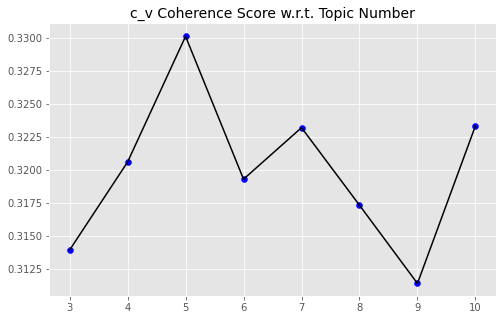

In [197]:
##https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))
##eliminate rare and frequent tokens
#id2token_risk_article.filter_extremes(no_below=2, no_above=0.8, 
#                                       keep_tokens=['smoke','smoking','smoker'])
corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
    #cm = CoherenceModel(model=lda_model, corpus=corpus_smoke_article, coherence='u_mass')
    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

In [199]:
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=6, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -8.166399321990331


/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/3518099681.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/3518099681.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/3518099681.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/3518099681.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=words, fontsize=14)
/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/3518099681.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(la

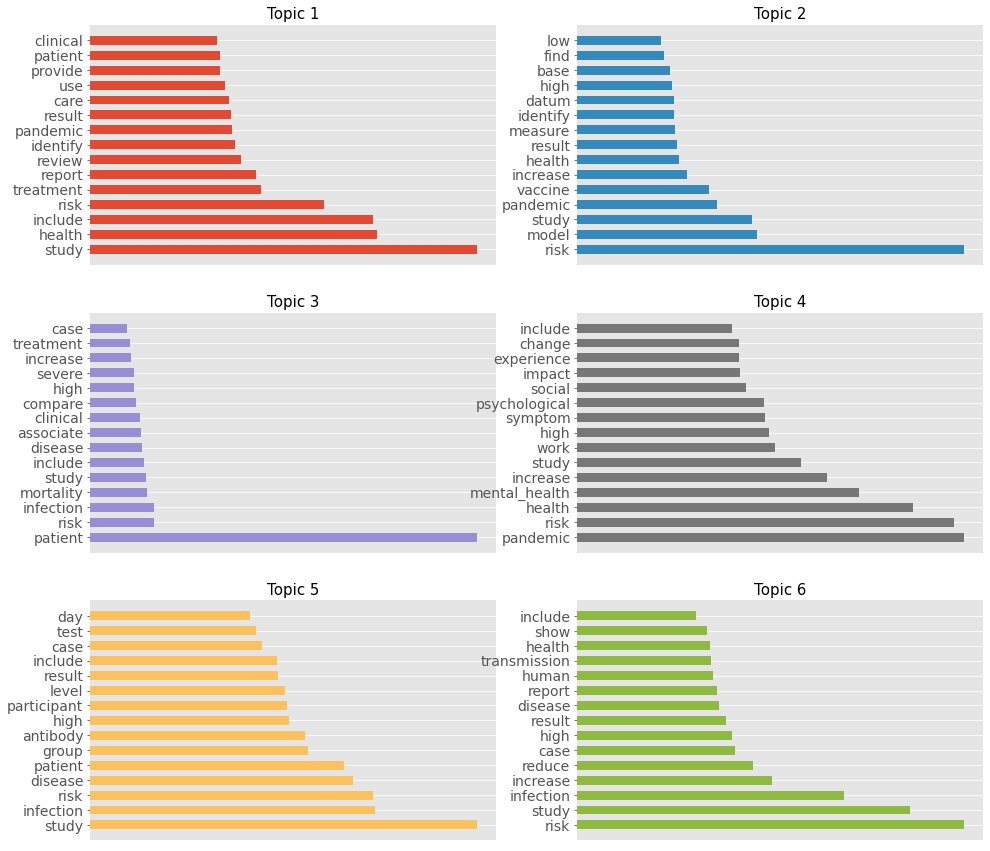

In [200]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(3,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

In [201]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/User

CPU times: user 891 ms, sys: 1.04 s, total: 1.93 s
Wall time: 4.19 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.132877 -0.089403       1        1  32.383007
0     -0.056603 -0.054756       2        1  16.730464
1     -0.077729  0.025124       3        1  16.002007
5      0.017102  0.045337       4        1  14.271595
3     -0.092925 -0.025044       5        1  11.920138
4      0.077278  0.098742       6        1   8.692789, topic_info=              Term         Freq        Total Category  logprob  loglift
57         patient  3674.000000  3674.000000  Default  30.0000  30.0000
309         health   773.000000   773.000000  Default  29.0000  29.0000
362      mortality   518.000000   518.000000  Default  28.0000  28.0000
274  mental_health   251.000000   251.000000  Default  27.0000  27.0000
138      infection   986.000000   986.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
307           find    48.708246   478.543519   Topic6  -5.8880   0.1578
153        receive    43.333064   319.650556   Topic6  -6.0049   0.4444
735       response    42.661121   352.455422   Topic6  -6.0205   0.3310
943        vaccine    41.631357   351.417805   Topic6  -6.0450   0.3096
200       identify    41.849521   620.020038   Topic6  -6.0398  -0.2530

[526 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
2197       3  0.893996  acceptance
14850      6  0.966360        acne
494        1  0.849221       acute
494        2  0.031926       acute
494        3  0.019155       acute
...      ...       ...         ...
2383       2  0.156650       worry
2383       3  0.678817       worry
2383       4  0.104433       worry
2383       5  0.026108       worry
14319      6  0.855488        znpp

[1305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 6, 4, 5])

In [202]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/1691480270.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)


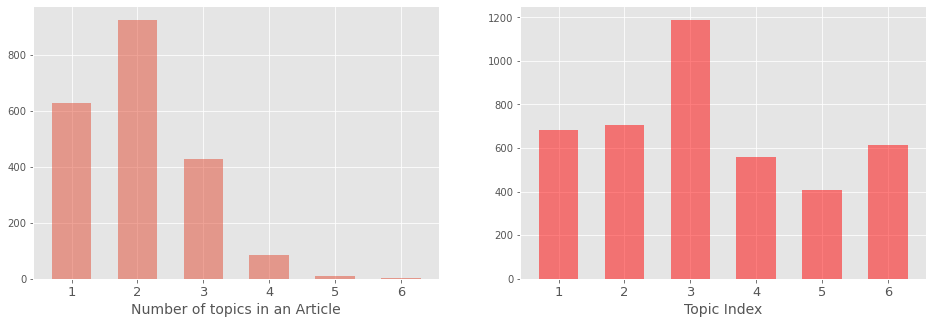

In [203]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6'],fontsize=13)

In [204]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),6))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5
0,0.782529,0.000000,0.211763,0.000000,0.0,0.000000
1,0.112750,0.000000,0.624808,0.258893,0.0,0.000000
2,0.596512,0.396475,0.000000,0.000000,0.0,0.000000
3,0.126396,0.033325,0.000000,0.067821,0.0,0.768689
4,0.000000,0.541945,0.000000,0.000000,0.0,0.447014


In [205]:
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Treatment Methods', 1: 'Mental Health and Behavior', 2: 'Severity of Disease', 
                  3: 'Transmission of Virus', 4: 'Public and Social Service', 5:'Death'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/Users/laiduy98/miniconda3/envs/ter/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [125]:
meta_df.count()

cord_uid            613033
sha                 239783
source_x            613033
title               612936
doi                 403326
pmcid               225785
pubmed_id           279423
license             613033
abstract            613033
publish_time        613033
authors             609795
journal             546459
mag_id                   0
who_covidence_id    285027
arxiv_id             10899
pdf_json_files      239783
pmc_json_files      197268
url                 416398
s2_id               574467
dtype: int64

In [137]:
all_json = ! ls $root_path/document_parses/pdf_json
# all_json = meta_df['pdf_json_files'].tolist()
len(all_json)

375999

In [138]:
all_json[:5]

['0000028b5cc154f68b8a269f6578f21e31f62977.json',
 '0000b6da665726420ab8ac9246d526f2f44d5943.json',
 '0000b93c66f991236db92dc16fa6db119b27ca12.json',
 '0000fcce604204b1b9d876dc073eb529eb5ce305.json',
 '000122a9a774ec76fa35ec0c0f6734e7e8d0c541.json']

In [132]:
all_json = [root_path + "" + s for s in all_json]
all_json[:5]

TypeError: can only concatenate str (not "float") to str

In [84]:
with open(all_json[0]) as file:
    x = json.load(file)
x['paper_id']

# meta_df['sha']

'0000028b5cc154f68b8a269f6578f21e31f62977'

In [70]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            # self.publish_time = content['publish_time']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

KeyError: 'publish_time'

In [8]:
!conda install tqdm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [9]:
from tqdm import tqdm
all_json_clean = list()
for idx, entry in tqdm(enumerate(all_json), total=len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.body_text) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

100%|████████████████████████████████████████████████████████████████| 375999/375999 [06:23<00:00, 980.51it/s]


375671

In [10]:
import random

random.seed(42)

all_json = random.sample(all_json, 1000)

In [11]:
all_json[:5]

['../../archive/document_parses/pdf_json/e4bf914ff5ecb0354592d057a9c65085e2e5551c.json',
 '../../archive/document_parses/pdf_json/27cc1a09b777705b9c31e04946cb5e7c07d9ef77.json',
 '../../archive/document_parses/pdf_json/08fda7c00c1c8172848df107ddc48de16ec1489a.json',
 '../../archive/document_parses/pdf_json/6207e26ce53cc5b810baec60c0ead184cf3eb78a.json',
 '../../archive/document_parses/pdf_json/5756f748eb5e3dae569b6c4568caca120b137b50.json']

In [12]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [69]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': [], 'publish_time': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    dict_['publish_time'].append(content.publish_time)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

  0%|                                                                                | 0/1000 [00:00<?, ?it/s]


AttributeError: 'FileReader' object has no attribute 'publish_time'

In [14]:
# df_covid['body_text'][2]

# Preprocessing
## Handling multiple languages

In [26]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████████████████████████████████████████████████████████████████| 894/894 [00:04<00:00, 185.13it/s]


In [27]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 894

{'de': 11, 'en': 865, 'es': 9, 'fr': 9}


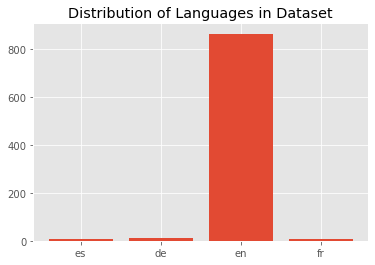

In [28]:
df_covid['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [29]:
df = df_covid[df_covid['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 893
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          865 non-null    object
 1   doi               839 non-null    object
 2   abstract          865 non-null    object
 3   body_text         865 non-null    object
 4   authors           851 non-null    object
 5   title             865 non-null    object
 6   journal           788 non-null    object
 7   abstract_summary  865 non-null    object
 8   language          865 non-null    object
dtypes: object(9)
memory usage: 67.6+ KB


In [32]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    pat = r'\d+'
    text = re.sub(pat, '', text)
    # r'[^a-zA-z0-9.,!?/:;\"\'\s]
    # r'[^\w\s]
    
    # text = text.replace(r'\d+','')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    # removed_numbers = dataframe.str.replace(r'\d+','')
        
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [33]:
def apply_preprocess(df):
    df["body_text_clean"] = df["body_text"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [40]:
def apply_preprocess_abstract(df):
    df["abstract_clean"] = df["abstract"].apply(lambda x: 
              utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
              lst_stopwords=lst_stopwords))
    return df

In [42]:
df = apply_preprocess(df)

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/124836987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["body_text_clean"] = df["body_text"].apply(lambda x:


In [43]:
df = apply_preprocess_abstract(df)
df.head()

/var/folders/yf/jsht06l94t5_wb6s1c65k6v40000gn/T/ipykernel_1105/1022252229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["abstract_clean"] = df["abstract"].apply(lambda x:


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,body_text_clean,abstract_clean
0,e4bf914ff5ecb0354592d057a9c65085e2e5551c,10.1111/psyg.12617,,COVID-19 spreads from person to person through...,"Kobayashi, Ryota. Hayashi, Hiroshi. <br>Kawa...",Recognition of the coronavirus disease 2019<b...,Psychogeriatrics,Not provided.,en,covid spread person person saliva droplet aero...,
2,6207e26ce53cc5b810baec60c0ead184cf3eb78a,10.1007/s00406-020-01196-x,"Due to the ongoing COVID-19 pandemic, an unpre...",Quarantine and isolation are main containment ...,"Henssler, Jonathan. Stock, Friederike. van<...",Mental health effects of infection<br>contain...,Eur Arch Psychiatry Clin Neurosci,"Due to the ongoing COVID-19 pandemic, an<br>u...",en,quarantine isolation main containment strategy...,ongoing covid pandemic unprecedented number pe...
3,5756f748eb5e3dae569b6c4568caca120b137b50,10.1016/b978-0-7020-2488-7.50022-3,"publicly funded repositories, such as the WHO ...",While weight loss is a common presenting probl...,"Gunn-Moore, Danièlle. Miller, James B",The cat with weight loss and a good appetite,Problem-Based Feline Medicine,"publicly funded repositories, such as the WHO...",en,weight loss common presenting problem feline m...,publicly funded repository covid database unre...
4,4f8cca4f5378dc2cfc32749a8a337bfca48a81e1,10.1016/j.micpath.2020.104452,"M.M, S.M.M, and A.G. drafted the study concept...",Since the first observation of probiotic bacte...,"Mahooti, Mehran. Miri, Seyed Mohammad. <br>A...",The immunomodulatory effects of probiotics on...,Microb Pathog,"M.M, S.M.M, and A.G. drafted the study concep...",en,observation probiotic bacteria elie metchnikof...,mm smm ag drafted study concept design mm ea a...
5,31d6a29184dbf37731de9537bfdb4b7e2cf8871a,10.3390/ijerph18158121,,The Internet and social media platforms are cr...,"Green, Gizell. Tesler, Riki. Sharon, Cochava","Perceived Efficiency Outcomes, Sources and<br...",Int J Environ Res Public Health,Not provided.,en,internet social medium platform crucial venue ...,


In [94]:
# dropping null value columns to avoid errors
df_test = df.dropna()
 
# substring to be searched
sub = 'severity'

sub2 = 'risk factor'
 
# creating and passing series to new column
# df_test["abstract_sev_index"]= df_test["abstract_clean"].str.find(sub)
# df_test["abstract_ris_index"]= df_test["abstract_clean"].str.find(sub2)

df_test = df_test[df_test['abstract_clean'].str.contains('severity|risk factor')]
 

In [91]:
# df_test[df_test['abstract_ris_index'] != -1]['abstract_clean']

'background unclear asthma allergic phenotype risk factor hospitalization severe disease sarscov method patient day old testing positive sarscov march september retrospectively identified characterized electronic analysis stanford subcohort followed prospectively evaluate longterm covid symptom result patient underwent sarscov testing tested positive multivariate analysis asthma independent risk factor hospitalization ci p sarscovpositive asthmatic allergic asthma lowered risk hospitalization protective effect compared nonallergic asthma p association baseline medication use characterized gina hospitalization risk patient severe covid disease lower eosinophil level hospitalization compared patient mild asymptomatic disease'

In [92]:
df_test = df_test[df_test['abstract_sev_index'] != -1 or df_test['abstract_ris_index'] != -1]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [99]:
df_test['abstract_clean'][48]

'objective present study aimed explore effect risk factor associated covid outbreak experience parent childrens wellbeing method parent child aged yearsold completed online survey reporting home environment condition relation pandemic consequence difficulty experienced quarantine perception individual parentchild dyadic stress childrens emotional behavioral problem result result showed perception difficulty quarantine crucial factor undermines parent childrens wellbeing quarantine impact childrens behavioral emotional problem mediated parent individual dyadic stress stronger effect parent reported difficulty dealing quarantine stress turn increase childrens problem living atrisk area quality home environment relation pandemic consequence effect family wellbeing conclusion dealing quarantine particularly stressful experience parent balance personal life work raising child left resource situation put parent higher risk experiencing distress potentially impairing ability supportive caregi

In [160]:
df_test.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,language,body_text_clean,abstract_clean
48,bf712b5ee5262afca68c21b7e497974e97ef8b56,10.3389/fpsyg.2020.01713,Objectives: The present study aimed to explore...,"On 30th of January 2020, WHO declared a Public...","Spinelli, Maria. Lionetti, Francesca. <br>Pa...",Parents' Stress and Children's Psychological<...,Front Psychol,Objectives: The present study aimed to explor...,en,th january declared public health emergency in...,objective present study aimed explore effect r...
110,31df99896f7fb99942250146a1248181916e1fe1,10.1111/all.14972,Background: It is unclear whether asthma and i...,The role of comorbid conditions in susceptibil...,"Eggert, Lauren E.. He, Ziyuan. Collins,<br>...","Asthma phenotypes, associated<br>comorbiditie...",Allergy,Background: It is unclear whether asthma and<...,en,role comorbid condition susceptibility sarscov...,background unclear asthma allergic phenotype r...
168,ae14ff70e0525c279ed23313eedd34c0073f8727,10.1016/j.drugalcdep.2021.109231,Examining the impact of social distancing and ...,"In early 2020, the increase in COVID-19 cases ...","Xavier Hall, Casey D.. Javanbakht, Marjan. <...",Examining the impact of social distancing and...,Drug Alcohol Depend,Examining the impact of social distancing and...,en,early increase covid case resulted policy mult...,examining impact social distancing methampheta...
178,1e95896c61e43bc53e391ed4cb8f0a8220267621,10.1016/j.bbih.2020.100163,Manuscript word count (without references and ...,Severe acute respiratory syndrome coronavirus ...,"Almeria, M.. Cejudo, J.C.. Sotoca, J.. Deu...",Cognitive profile following COVID-19<br>infec...,Brain Behav Immun Health,Manuscript word count (without references and...,en,severe acute respiratory syndrome coronavirus ...,manuscript word count reference table j o u r ...
181,be266052f2a2ed3ceb8b84dd3800608e8414ad4a,10.1080/20009666.2021.1883814,There is growing evidence in support of ischem...,Although the most common presentation of COVID...,"Owolabi, Lukman Femi. Raafat, Ahmed. Enwere...",Hemorrhagic infarctive stroke in COVID-19<br>...,Journal of community hospital internal medicin...,There is growing evidence in support of<br>is...,en,common presentation covid infection respirator...,growing evidence support ischemic stroke manif...


In [ ]:
# !pip install scispacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bc5cdr_md-0.5.0.tar.gz
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz

In [ ]:
def extract_paper_annotations():
    """
    This function looks at all the papers in the CORD-19 dataset and extract entities
    """
    # Define the list of papers we will process
    #papers = [Path("/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/59eab95c43fdea01481fdbf9bae45dfe28ffc693.json")]
    papers = [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('comm_use_subset/comm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('noncomm_use_subset/noncomm_use_subset/pdf_json/*.json')]
    #papers += [p for p in Path('/kaggle/input/CORD-19-research-challenge').glob('custom_license/custom_license/pdf_json/*.json')]
    print (len(papers)) 

    # Load the NLP models
    nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...
    nlp_model_bc5cdr = spacy.load("en_ner_bc5cdr_md") # For diseases

    # The output will be one hashmap associating each paper to its annotations
    output = {}

    # Process all the papers
    for paper in tqdm(papers):
        try:
            # Load the document
            document = json.loads(paper.read_text())

            # Get the ID
            paper_id = document['paper_id']
            
            # Initialise its entry
            output[paper_id] = {}
            output[paper_id]['topics'] = {} # The different topic annotations grouped per type
            
            # Group the text by sections (took more than 9h to process!)
            #section_texts = {}
            #section_texts['abstract'] = []
            #for b in document['abstract']:
            #    section_texts['abstract'].append(b['text'])
            #for b in document['body_text']:
            #    section_texts.setdefault(b['section'], [])
            #    section_texts[b['section']].append(b['text'])

            # Retrieve all the text
            texts = []
            for b in document['abstract']:
                texts.append(b['text'])
            if 'body_text' in document:
                for b in document['body_text']:
                    texts.append(b['text'])
            
            # Process the different sections to extract entities
            #for section,texts in section_texts.items():
            text = '.'.join(texts)
            for nlp_model in [nlp_model_bionlp13cg, nlp_model_bc5cdr]:
                tokens = nlp_model(text)
                for entity in tokens.ents:
                    topic_type = entity.label_
                    topic_value = str(entity.text)
                    output[paper_id]['topics'].setdefault(topic_type, set())
                    output[paper_id]['topics'][topic_type].add(topic_value)
            
        except Exception as e:
            print ('Error with {}'.format(paper))
            print (e)

    # Turn the sets into lists to save them as JSON
    for paper_id in output.keys():
        for topic_type in output[paper_id]['topics'].keys():
            output[paper_id]['topics'][topic_type] = list(output[paper_id]['topics'][topic_type])

    return output

In [101]:
import scispacy
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")
nlp_model_bionlp13cg = spacy.load('en_ner_bionlp13cg_md') # For cells, genes, ...


In [106]:
doc = nlp(df_test['body_text'][110])

In [107]:
print("TEXT", "START", "END", "ENTITY TYPE")
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

TEXT START END ENTITY TYPE
infection 64 73 DISEASE
viral infections 225 241 DISEASE
asthma exacerbations 265 285 DISEASE
infections 366 376 DISEASE
OC43 428 432 DISEASE
asthma exacerbations 447 467 DISEASE
respiratory illness 538 557 DISEASE
viral pneumonia 571 586 DISEASE
infection 799 808 DISEASE
asthma 977 983 DISEASE
COVID-19 infection 1480 1498 DISEASE
COVID-19 illness 1507 1523 DISEASE
non-asthmatic 1730 1743 DISEASE
COVID-19 disease 2199 2215 DISEASE
allergic 2363 2371 DISEASE
COVID-19 disease 2419 2435 DISEASE
COVID-19 disease 2687 2703 DISEASE
allergic 2840 2848 DISEASE
COVID-19 disease 2895 2911 DISEASE
asthma 3029 3035 CHEMICAL
asthma 3252 3258 DISEASE
respiratory disease 3820 3839 DISEASE
asthma 3946 3952 DISEASE
COVID-19 disease 4188 4204 DISEASE
allergic asthma 4236 4251 DISEASE
allergic asthma 4447 4462 DISEASE
allergic asthma 4519 4534 DISEASE
COVID-19 disease 4548 4564 DISEASE
eosinophilia 4996 5008 DISEASE
allergic inflammation 5044 5065 DISEASE
COVID-19 infection 511

In [38]:
for i in df['body_text_clean']:
    print(i)
    if 

0    covid spread person person saliva droplet aero...
2    quarantine isolation main containment strategy...
3    weight loss common presenting problem feline m...
4    observation probiotic bacteria elie metchnikof...
5    internet social medium platform crucial venue ...
Name: body_text_clean, dtype: object